# Introduction

The notebook examines the following:
* pyldpc for encoding and decoding of AWGN and Rayleigh-Jakes SOS channels
* Plotting BER vs SNR for uncoded and coded Rayleigh-Jakes channel
* Encoding and decoding in VAR case and potential integrations

Encoding -
- using a sparse parity-check matrix to place constraints on the parity bits
- uses a generator matrix to actually get the parity bits from the data bits

Decoding - for our channel, uses the sum-product message passing/belief propagation algorithm - need to understand in more detail

# pyldpc

Parameters:
- k = the number of bits to be transmitted originally before coding - this is the data we want to send per packet, so more packet size increases latency
- n = the number of bits to be transmitted after coding is done on k bits, so n-k parity bits is used
- H = parity check matrix
- G = generator matrix
- d_v = degree of the variable node - number of 1s per column in H
- d_c = degree of the check node - number of 1s per row in H

d_v and d_C along with n specify the structure of H and G. 

H has n columns and (n * d_v/d_c) = m rows. 

The rate of coding R = 1 - (m/n) = k/n

Closer R is to 1, more uncoded the data is, suitable for less noise or no noise. 

In [5]:
pip install pyldpc

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
from pyldpc import make_ldpc, encode, decode, get_message
from utils import *
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
import json
from statsmodels.tsa.ar_model import AutoReg
import numpy as np
from sympy import Matrix
import json
import argparse
from math import log

In [3]:
#Demo with 11 bits (0 and 1) to be transmitted
#0 becomes 1 and 1 becomes -1 in symbol, coding is done before converting to a symbol, and decoding of the message occurs after converting the symbols to bits
n1 = 18
d_v1 = 3
d_c1 = 6
snr = 10
k = 11 #fixed if we fix the other 3 (not snr)

In [5]:
def transmit_data_awgn_real(data, snr_db):
    """
    Simulate data transmission over a wireless channel with noise.

    Args:
        data (np.ndarray): Input data to be transmitted.
        channel (complex or float): Channel gain.
        snr_db (float): Signal-to-noise ratio in decibels (dB). The formula to convert in linear scale is snr(dB) = 10log(snr(linear))

    Returns:
        np.ndarray: Noisy received signal.
    """
    # Apply channel gain to the transmitted data.
    signal = data
    # Calculate the signal power.
    signal_power = np.mean(np.abs(signal)**2)
    # Convert SNR from dB to linear scale and compute noise power.
    noise_power = signal_power / (10**(snr_db / 10))
    # Generate complex Gaussian noise.
    noise = np.sqrt(noise_power / 2) * (np.random.randn(len(data)))
    # Add noise to the signal to create the received signal.
    return signal + noise

def transmit_data_awgn_complex(data, snr_db):
    """
    Simulate data transmission over a wireless channel with noise.

    Args:
        data (np.ndarray): Input data to be transmitted.
        channel (complex or float): Channel gain.
        snr_db (float): Signal-to-noise ratio in decibels (dB). The formula to convert in linear scale is snr(dB) = 10log(snr(linear))

    Returns:
        np.ndarray: Noisy received signal.
    """
    # Apply channel gain to the transmitted data.
    signal = data
    # Calculate the signal power.
    signal_power = np.mean(np.abs(signal)**2)
    # Convert SNR from dB to linear scale and compute noise power.
    noise_power = signal_power / (10**(snr_db / 10))
    # Generate complex Gaussian noise.
    noise = np.sqrt(noise_power / 2) * (np.random.randn(len(data)) + 1j * np.random.randn(len(data)))
    # Add noise to the signal to create the received signal.
    return signal + noise

### LDPC with real noise on AWGN channel

In [10]:
n = 18
k = 11

In [12]:
#Generate message
original_message = np.random.randint(2, size=k)  # Random 11-bit message
print(f"Original Message: {original_message}")

#Create the parity-check and generator matrices which depend on n, d_v and d_c
H1, G1 = make_ldpc(n, d_v1, d_c1, systematic=True, sparse=True)
print(G1.shape)

#Encoding
#The encode() function automatically adds real noise
encoded_message1 = encode(G1, original_message, snr) 
print(f"Encoded Message: {encoded_message1}")

#Decoding of the bits after converting all the received symbols into bits - the decode function handles the AWGN channel estimation as a hard decoder
decoded_message1 = decode(H1, encoded_message1, snr)
print(f"Decoded Message: {decoded_message1}")

#Decoding of code bits into original data bits
recovered_message1 = get_message(G1, decoded_message1)
print(f"Recovered Message: {recovered_message1}")

#BER
ber = 0
for i in range(len(original_message)):
    if original_message[i] != recovered_message1[i]:
        ber += 1
ber = ber/len(original_message)
print(ber)

Original Message: [0 0 1 1 1 0 1 1 0 0 1]
(18, 11)
Encoded Message: [ 1.30177968  0.80841796 -0.98856921 -1.48157113 -1.24204593  1.14915066
 -0.09067996 -1.04059708  0.63919403  0.49017804 -0.58186513  0.7900881
 -1.50850844  0.66798533 -1.13745063  1.33995605 -0.62286712 -1.20160823]
Decoded Message: [0 0 1 1 1 0 1 1 0 0 1 0 1 0 1 0 1 1]
Recovered Message: [0 0 1 1 1 0 1 1 0 0 1]
0.0


### LDPC with complex noise on AWGN channel

2 issues:
- no customizability
- the encode() function adds only real noise, and the decode() function is valid only for AWGN channels

In [14]:
def encode_custom(tG, v, seed=None):
    """Encode a binary message and adds Gaussian noise.

    Parameters
    ----------
    tG: array or scipy.sparse.csr_matrix (m, k). Transposed coding matrix
    obtained from `pyldpc.make_ldpc`.

    v: array (k, ) or (k, n_messages) binary messages to be encoded.

    snr: float. Signal-Noise Ratio. SNR = 10log(1 / variance) in decibels.

    Returns
    -------
    y: array (n,) or (n, n_messages) coded messages + noise.

    """
    n, k = tG.shape
    rng = check_random_state(seed)
    d = binaryproduct(tG, v)
    x = (-1) ** d
    y = x
    return y

def decoder_custom(received):
    list1 = np.sign(np.real(received))
    list2 = []
    for i in list1:
        if i == -1:
            list2.append(1)
        if i == 1:
            list2.append(0)
    return list2

In [22]:
#Generate message
original_message = np.random.randint(2, size=k)  # Random 11-bit message
print(f"Original Message: {original_message}")

#Create the parity-check and generator matrices which depend on n, d_v and d_c
H2, G2 = make_ldpc(n1, d_v1, d_c1, systematic=True, sparse=True)
print(H2)

#Encoding
encoded_message2 = encode_custom(G2, original_message) 
print(f"Encoded Message: {encoded_message2}")

#Transmission of encoded signal through the channel
received_message2 = transmit_data_awgn_complex(encoded_message2, snr)
print(f"Received Message: {received_message2}")

#Decoding of the bits from symbols
decoded_message2 = decode(H2, received_message2.real, snr)
print(f"Decoded Message: {decoded_message2}")

#Decoding of code bits into original data bits
recovered_message2 = get_message(G2, decoded_message2)
print(f"Recovered Message: {recovered_message2}")

#BER
ber = 0
for i in range(len(original_message)):
    if original_message[i] != recovered_message2[i]:
        ber += 1
ber = ber/len(original_message)
print(ber)

Original Message: [0 1 0 1 0 1 1 1 1 0 1]
[[0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 0 0]
 [1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1]
 [1 0 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0]
 [0 0 0 0 1 0 1 0 1 0 1 0 0 1 0 0 0 1]
 [0 1 0 0 0 1 0 1 0 1 0 0 1 0 0 0 1 0]
 [0 0 1 0 0 0 0 0 0 0 1 0 1 1 1 0 1 0]
 [1 0 0 1 1 0 1 1 0 0 0 0 0 0 0 1 0 0]
 [0 1 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 1]]
Encoded Message: [ 1 -1  1 -1  1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1  1]
Received Message: [ 0.90160616+0.22422986j -0.94113897-0.20838693j  1.16610367+0.13269653j
 -0.99416187+0.47560664j  1.21489937-0.25026968j -1.17395248+0.17348763j
 -0.6276546 -0.37629922j -1.18471943-0.1981663j  -1.18016555-0.00188892j
  1.06370662-0.25221117j -1.25551656+0.08319651j -0.73929871+0.35985934j
 -1.08315259-0.13675389j -1.21862607+0.15923636j -0.64422392+0.04408728j
 -1.06379571-0.27708905j  1.17100977-0.02967936j  1.00732849-0.13813121j]
Decoded Message: [0 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 0 0]
Recovered Message: [0

In [ ]:
H2, G2 = make_ldpc(216, 3, 6, systematic=True, sparse=True)
print(G2.shape)

### Defining Useful Helper Functions

In [13]:
def generate_random_symbols(n):
    """
    Generate random bits as either -1 or 1.

    Args:
        n (int): Number of bits to generate.

    Returns:
        np.ndarray: Array of random bits (-1 or 1) of size n.
    """
    # Generate n random bits as -1 or 1 using uniform sampling.
    return np.random.choice([-1, 1], size=n)

def transmit_data(data, channel, snr_db):
    """
    Simulate data transmission over a wireless channel with noise.

    Args:
        data (np.ndarray): Input data to be transmitted.
        channel (complex or float): Channel gain.
        snr_db (float): Signal-to-noise ratio in decibels (dB). The formula to convert in linear scale is snr(dB) = 10log(snr(linear))

    Returns:
        np.ndarray: Noisy received signal.
    """
    # Apply channel gain to the transmitted data.
    signal = channel * data
    # Calculate the signal power.
    signal_power = np.mean(np.abs(signal)**2)
    # Convert SNR from dB to linear scale and compute noise power.
    noise_power = signal_power / (10**(snr_db / 10))
    # Generate complex Gaussian noise.
    noise = np.sqrt(noise_power / 2) * (np.random.randn(len(data)) + 1j * np.random.randn(len(data)))
    # Add noise to the signal to create the received signal.
    return signal + noise

def transmit_data_awgn(data, snr_db):
    """
    Simulate data transmission over a wireless channel with noise.

    Args:
        data (np.ndarray): Input data to be transmitted.
        channel (complex or float): Channel gain.
        snr_db (float): Signal-to-noise ratio in decibels (dB). The formula to convert in linear scale is snr(dB) = 10log(snr(linear))

    Returns:
        np.ndarray: Noisy received signal.
    """
    # Apply channel gain to the transmitted data.
    signal = data
    # Calculate the signal power.
    signal_power = np.mean(np.abs(signal)**2)
    # Convert SNR from dB to linear scale and compute noise power.
    noise_power = signal_power / (10**(snr_db / 10))
    # Generate complex Gaussian noise.
    noise = np.sqrt(noise_power / 2) * (np.random.randn(len(data)) + 1j * np.random.randn(len(data)))
    # Add noise to the signal to create the received signal.
    return signal + noise

def estimate_channel(received, data):
    """
    Estimate the channel coefficient using least squares.

    Args:
        received (np.ndarray): Received signal.
        data (np.ndarray): Transmitted data.

    Returns:
        complex or float: Estimated channel coefficient, of the same length as X, so a packetwise(pointwise) estimation is performed
    """
    # Reshape the transmitted data for matrix operations.
    X = data.reshape(-1, 1)
    # Perform least squares estimation to solve for the channel.
    h = np.linalg.lstsq(X, received, rcond=None)[0][0]
    return h

def collect_pilot_estimates(current_index, num_pilots, channel_vals):
    """
    Transmit pilots and get channel estimates which are then fed to autoregressive predictive models

    Args:
        current_index (int): Starting index at which pilots are retransmitted.
        num_pilots (int): Number of pilot transmissions to perform.
        channel_vals (np.ndarray): Array of actual channel values.

    Returns:
        tuple: 
            - estimates (list): List of estimated channel coefficients for each pilot.
            - current_index (int): Updated index after processing pilots.
    """
    # List to store channel estimates.
    estimates = []
    # Collect channel estimates for the specified number of pilots.
    for _ in range(num_pilots):
        # Check if the remaining channel values are sufficient for a pilot.
        if current_index + pilot_size > len(channel_vals):
            break

        # Generate pilot bits for transmission.
        pilot_bits = generate_random_bits(pilot_size)
        # Extract the actual channel values for the current pilot.
        actual_channel = channel_vals[current_index:current_index + pilot_size]
        # Simulate the transmission and reception of pilot data.
        received_pilot = transmit_data(pilot_bits, actual_channel, snr_db)
        # Estimate the channel from the received pilot data.
        hbar = estimate_channel(received_pilot, pilot_bits)
        # Store the estimated channel coefficient.
        estimates.append(hbar)
        # Move the index forward by the size of the pilot.
        current_index += pilot_size

    return estimates, current_index


def predict_channel_var(channel_history, steps=1):
    """
    Predict the future channel value using a Vector AutoRegressive (VAR) model.

    Args:
        channel_history (np.ndarray): Historical channel values as a 1D array of complex numbers.
        steps (int): Number of future steps to predict. Default is 1.

    Returns:
        complex: Predicted channel value as a complex number.

    Raises:
        ValueError: If the length of `channel_history` is less than or equal to the VAR model order.
    """
    # Ensure there are enough samples for the VAR model.
    if len(channel_history) <= var_order:
        raise ValueError(f"Not enough samples for VAR. Need >{var_order}, got {len(channel_history)}")
    # Separate real and imaginary parts of the channel history for the VAR model.
    channel_history_separated = np.column_stack((np.real(channel_history), np.imag(channel_history)))
    # Create and fit the VAR model using the specified order.
    model = VAR(channel_history_separated)
    results = model.fit(var_order)
    # Forecast future values based on the fitted model and past data.
    forecast = results.forecast(channel_history_separated[-var_order:], steps=steps)
    # Combine the real and imaginary parts to return the predicted complex channel value.
    return forecast[0, 0] + 1j * forecast[0, 1]


def generate_channels_for_doppler_frequencies(Fd, Fs, N):
    """
    Generate correlated Jakes channels for given Doppler frequencies using the Sum-of-Sinusoids (SoS) method.

    Args:
        Fd (float): Maximum Doppler frequency (Hz).
        Fs (float): Sampling frequency (Hz).
        N (int): Number of samples to generate.

    Returns:
        np.ndarray: Correlated Jakes random variables (complex values) for the generated channels.
    """
    def jakes_sos(P, K, Fs, Fd, N, typ):
        """
        Generate Jakes random variables using the Sum-of-Sinusoids (SoS) method.

        Args:
            P (int): Number of time points.
            K (int): Number of independent processes.
            Fs (float): Sampling frequency (Hz).
            Fd (float): Maximum Doppler frequency (Hz).
            N (int): Number of sinusoids used in the model.
            typ (str): Type of signal to generate ('comp' for complex, others for real).

        Returns:
            np.ndarray: Jakes random variables (complex values).
        """
        # Create a time vector for sampling points
        t = np.linspace(0, P / Fs, P)
        # Calculate angular Doppler frequency
        omega_d = 2 * np.pi * Fd
        # Initialize an array to store Jakes random variables
        jakes_rvs = np.zeros((K, P), dtype=complex)
        
        # Loop through independent processes
        for k in range(K):
            # Generate random angles for sinusoids
            alpha = np.random.uniform(0, 2 * np.pi, N)
            # Adjust angles based on the number of sinusoids
            alpha_m = np.array([((2 * np.pi * n) - np.pi + al) / (4 * N) for n, al in enumerate(alpha)])
            # Generate random phase offsets for cosine terms
            a_m = np.random.uniform(0, 2 * np.pi, N)
            # Generate random phase offsets for sine terms
            b_m = np.random.uniform(0, 2 * np.pi, N)
            # Compute cosine terms for the real part
            cosine_terms = np.cos((omega_d * t[:, None] * np.cos(alpha_m)) + a_m)
            # Sum the cosine contributions to form the real part
            real_part = np.sqrt(1 / N) * np.sum(cosine_terms, axis=1)

            # Check if generating complex signals
            if typ == 'comp':
                # Compute sine terms for the imaginary part
                sine_terms = np.sin((omega_d * t[:, None] * np.cos(alpha_m)) + b_m)
                # Sum the sine contributions to form the imaginary part
                imag_part = np.sqrt(1 / N) * np.sum(sine_terms, axis=1)
                # Combine real and imaginary parts
                jakes_rvs[k] = real_part + 1j * imag_part
            else:
                # Enforce complex format with zero imaginary part for real signals
                jakes_rvs[k] = real_part + 1j * 0

        # Return the generated Jakes random variables
        return jakes_rvs

    # Number of time points for the output
    P = N
    # Number of independent processes to simulate
    K = 1
    # Specify the type of random variables (complex)
    typ = 'comp'
    # Set the center frequency
    Fc = 1000000000
    # Generate Jakes random variables using the SoS method
    jakes_rvs = jakes_sos(P, K, Fs, Fd, 100, typ)
    correlated_jakes_rvs = jakes_rvs

    # Open a file to write the generated channels
    with open("channels.txt", "w") as fo:
        # Iterate through each sample
        for i in range(P):
            # Extract the i-th sample
            new_sample = correlated_jakes_rvs[:, i]
            # Serialize complex numbers as (real, imag) pairs
            new_sample_serialized = [(z.real, z.imag) for z in new_sample]
            # Write serialized sample to the file
            json.dump(new_sample_serialized, fo)
            # Add a newline after each serialized sample
            fo.write('\n')

    # Return the generated Jakes random variables
    return correlated_jakes_rvs

def number_of_symbols(N, n, k):
    T = N // (k)
    #This is the number of symbols to be transmitted
    N1 = T*n
    return int(N1)

def decoder_custom_jakes(received, channel):
    list1 = np.sign(np.real(received / channel))
    list2 = []
    for i in list1:
        if i == -1:
            list2.append(1)
        if i == 1:
            list2.append(0)
    return list2

def decoder_custom_awgn(received):
    list1 = np.sign(np.real(received))
    list2 = []
    for i in list1:
        if i == -1:
            list2.append(1)
        if i == 1:
            list2.append(0)
    return list2

### LDPC with AWGN channel - plotting BER vs SNR

In [ ]:
def awgn_coded(N, SNR, n, d_v, d_c):
    H, G = make_ldpc(n, d_v, d_c, systematic=True, sparse=True)
    k = G.shape[1]
    rate = k/n
    snr_coded = SNR - 10 * np.log10(rate)
    # N is the number of message bits we want to transmit
    # But we want to send more than N symbols, and k is a fixed value, so we need to compute the number of symbols, and channel values, to generate
    N1 = number_of_symbols(N, n, k)
    
    # Initialize variables for simulation.
    current_index = 0  # Track the current position in channel values.
    total_packets = 0  # Total number of transmitted data bits.
    wrong_packets = 0  # Count of incorrectly received data bits.
    
    while current_index < N1:
        packet_message = np.random.randint(2, size=k)
         #The encoded packet is n symbols long
        encoded_packet_symbols = encode_custom(G, packet_message) 
        current_index += n
        received_symbols = transmit_data_awgn(encoded_packet_symbols, snr_coded)
        estimated_bits = decoder_custom_awgn(received_symbols)
        recovered_message = get_message(G, estimated_bits)
        
        total_packets += len(recovered_message)
        for i in range(len(packet_message)):
            if packet_message[i] != recovered_message[i]:
                wrong_packets += 1
                
    #Return the BER            
    if total_packets == 0:
        return None  # Return None if no packets were transmitted.
    else:
        return np.float16(wrong_packets / total_packets)

In [ ]:
def awgn_simulate(N, SNR):
    # Initialize variables for simulation.
    current_index = 0  # Track the current position in channel values.
    total_packets = 0  # Total number of transmitted data bits.
    wrong_packets = 0  # Count of incorrectly received data bits.
    
    while current_index < N:
        packet_message = np.random.randint(2, size = 1)
        current_index += 1
        packet_symbol = [-1 if j == 1 else 1 for j in packet_message]
        received_symbols = transmit_data_awgn(packet_symbol, SNR)
        recovered_message = decoder_custom_awgn(received_symbols)
        total_packets += 1
        if recovered_message != packet_message:
            wrong_packets += 1            
    if total_packets == 0:
        return None 
    else:
        return np.float16(wrong_packets / total_packets)       

In [ ]:
# Define the range of SNR values to be simulated
snr_values = [-6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
N = 100000
Fs = 100000
Fd = 100
n1 = 216
d_v1 = 3
d_c1 = 6
mse_threshold = 0.1

# Initialize lists to store BER for the two approaches
ber_coded_list_awgn = []  # BER for the autoregressive approach
ber_uncoded_list_awgn = []  # BER for the packetwise approach

# Simulation loop for each SNR value
# The simulation is peformed 3 times to ensure averaging and smoothness of the curve
for snr in snr_values:
    ber_coded_sum_awgn = 0  # For autoregressive approach
    ber_uncoded_sum_awgn = 0  # For packetwise approach
    for i in range(3):
        ber_coded_awgn = awgn_coded(N, snr, n1, d_v1, d_c1)
        ber_uncoded_awgn = awgn_simulate(N, snr)
        ber_coded_sum_awgn += ber_coded_awgn
        ber_uncoded_sum_awgn += ber_uncoded_awgn
    ber_coded_list_awgn.append(ber_coded_sum_awgn / 3)
    ber_uncoded_list_awgn.append(ber_uncoded_sum_awgn/ 3)


In [ ]:
plt.figure(figsize=(10, 6))
snr_values_np = np.array(snr_values)
# Plot the BER for the autoregressive approach
plt.plot(snr_values_np, ber_coded_list_awgn, marker='o', linestyle='-', label='Coded AWGN')
# Plot the BER for the packetwise approach
plt.plot(snr_values_np, ber_uncoded_list_awgn, marker='s', linestyle='--', label='Uncoded AWGN')
# Set the y-axis to a logarithmic scale
plt.yscale('log')
plt.xlabel('Eb/N0 (dB)', fontsize=14)
plt.ylabel('Bit Error Rate (BER)', fontsize=14)
plt.title('BER vs Eb/N0 for Coded and Uncoded BPSK over AWGN', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

### LDPC with AWGN + Rayleigh fading channel - plotting BER vs SNR

In [ ]:
def rayleigh_coded(N, SNR, n, d_v, d_c):
    H, G = make_ldpc(n, d_v, d_c, systematic=True, sparse=True)
    k = G.shape[1]
    rate = k/n
    snr_coded = SNR - 10 * np.log10(rate)
    # N is the number of message bits we want to transmit
    # But we want to send more than N symbols, and k is a fixed value, so we need to compute the number of symbols, and channel values, to generate
    N1 = number_of_symbols(N, n, k)
    
    # Initialize variables for simulation.
    current_index = 0  # Track the current position in channel values.
    total_packets = 0  # Total number of transmitted data bits.
    wrong_packets = 0  # Count of incorrectly received data bits.
    
    while current_index < N1:
        packet_message = np.random.randint(2, size=k)
         #The encoded packet is n symbols long
        encoded_packet_symbols = encode_custom(G, packet_message) 
        current_index += n
        channel = np.sqrt(0.5) * (np.random.randn(len(encoded_packet_symbols)) + 1j * np.random.randn(len(encoded_packet_symbols)))
        received_symbols = transmit_data(encoded_packet_symbols, channel, snr_coded)
        estimated_bits = decoder_custom_jakes(received_symbols, channel)
        recovered_message = get_message(G, estimated_bits)
        
        total_packets += len(recovered_message)
        for i in range(len(packet_message)):
            if packet_message[i] != recovered_message[i]:
                wrong_packets += 1
                
    #Return the BER            
    if total_packets == 0:
        return None  # Return None if no packets were transmitted.
    else:
        return np.float16(wrong_packets / total_packets)

In [ ]:
def rayleigh_simulate(N, SNR):
    wrong_packets = 0  # Count of incorrectly received data bits.
    channel_vals = (1 / np.sqrt(2)) * (np.random.randn(N) + 1j * np.random.randn(N)) 
    packet_message = np.random.randint(2, size = N)
    encoded_packet_symbols = [-1 if j == 1 else 1 for j in packet_message]
    received_symbols = transmit_data(encoded_packet_symbols, channel_vals, SNR)
    recovered_message = decoder_custom_jakes(received_symbols, channel_vals)
    for i in range(len(recovered_message)):
            if packet_message[i] != recovered_message[i]:
                wrong_packets += 1
    return np.float16(wrong_packets/N)
    #Return the BER            
    if total_packets == 0:
        return None  # Return None if no packets were transmitted.
    else:
        return np.float16(wrong_packets / total_packets)     

In [ ]:
# Define the range of SNR values to be simulated
snr_values = [-6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
N = 100000
Fs = 100000
Fd = 100
n1 = 216
d_v1 = 3
d_c1 = 6

# Initialize lists to store BER for the two approaches
ber_coded_list_ray = []  # BER for the autoregressive approach
ber_uncoded_list_ray = []  # BER for the packetwise approach

# Simulation loop for each SNR value
# The simulation is peformed 3 times to ensure averaging and smoothness of the curve
for snr in snr_values:
    ber_coded_sum_ray = 0  # For autoregressive approach
    ber_uncoded_sum_ray = 0  # For packetwise approach
    for i in range(3):
        ber_coded_ray = rayleigh_coded(N, snr, n1, d_v1, d_c1)
        ber_uncoded_ray = rayleigh_simulate(N, snr)
        ber_coded_sum_ray += ber_coded_ray
        ber_uncoded_sum_ray += ber_uncoded_ray
    ber_coded_list_ray.append(ber_coded_sum_ray / 3)
    ber_uncoded_list_ray.append(ber_uncoded_sum_ray/ 3)


In [ ]:
plt.figure(figsize=(10, 6))
snr_values_np = np.array(snr_values)
# Plot the BER for the autoregressive approach
plt.plot(snr_values_np, ber_coded_list_ray, marker='o', linestyle='-', label='Coded Rayleigh')
# Plot the BER for the packetwise approach
plt.plot(snr_values_np, ber_uncoded_list_ray, marker='s', linestyle='--', label='Uncoded Rayleigh')
# Set the y-axis to a logarithmic scale
plt.yscale('log')
plt.xlabel('Eb/N0 (dB)', fontsize=14)
plt.ylabel('Bit Error Rate (BER)', fontsize=14)
plt.title('BER vs Eb/N0 for Coded and Uncoded BPSK over uncorelated Rayleigh channel with AWGN', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

### LDPC with correlated Rayleigh channel (the channel is known)

In [ ]:
def corr_coded(Fd, Fs, N, SNR, n, d_v, d_c):
    H, G = make_ldpc(n, d_v, d_c, systematic=True, sparse=True)
    k = G.shape[1]
    rate = k/n
    snr_coded = SNR - 10 * np.log10(rate)
    # N is the number of message bits we want to transmit
    # But we want to send more than N symbols, and k is a fixed value, so we need to compute the number of symbols, and channel values, to generate
    N1 = number_of_symbols(N, n, k)
    
    # Initialize variables for simulation.
    current_index = 0  # Track the current position in channel values.
    total_packets = 0  # Total number of transmitted data bits.
    wrong_packets = 0  # Count of incorrectly received data bits.
    
    generate_channels_for_doppler_frequencies(Fd, Fs, N1)
    with open("channels.txt", "r") as f:
        channel_vals = [json.loads(line)[0] for line in f]
    channel_vals = np.array([complex(re, im) for re, im in channel_vals])
    
    while current_index < N1 - n:
        packet_message = np.random.randint(2, size=k)
         #The encoded packet is n symbols long
        encoded_packet_symbols = encode_custom(G, packet_message) 
        current_index += n
        channel = channel_vals[current_index:current_index + n]
        received_symbols = transmit_data(encoded_packet_symbols, channel, snr_coded)
        estimated_bits = decoder_custom_jakes(received_symbols, channel)
        recovered_message = get_message(G, estimated_bits)
        
        total_packets += len(recovered_message)
        for i in range(len(packet_message)):
            if packet_message[i] != recovered_message[i]:
                wrong_packets += 1
                
    #Return the BER            
    if total_packets == 0:
        return None  # Return None if no packets were transmitted.
    else:
        return np.float16(wrong_packets / total_packets)

In [ ]:
def corr_simulate(Fd, Fs, N, SNR):
    # Generate channels for the specified Doppler frequency and save to file.
    wrong_packets = 0
    generate_channels_for_doppler_frequencies(Fd, Fs, N)
    with open("channels.txt", "r") as f:
        channel_vals = [json.loads(line)[0] for line in f]
    channel_vals = np.array([complex(re, im) for re, im in channel_vals])
    packet_message = np.random.randint(2, size = N)
    encoded_packet_symbols = [-1 if j == 1 else 1 for j in packet_message]
    received_symbols = transmit_data(encoded_packet_symbols, channel_vals, SNR)
    recovered_message = decoder_custom_jakes(received_symbols, channel_vals)
    for i in range(len(recovered_message)):
            if packet_message[i] != recovered_message[i]:
                wrong_packets += 1
    return np.float16(wrong_packets/N)

In [ ]:
# Define the range of SNR values to be simulated
snr_values = [-6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
N = 100000
Fs = 100000
Fd = 100
n1 = 216
d_v1 = 3
d_c1 = 6

# Initialize lists to store BER for the two approaches
ber_coded_list_corr = []  # BER for the autoregressive approach
ber_uncoded_list_corr = []  # BER for the packetwise approach

# Simulation loop for each SNR value
# The simulation is peformed 3 times to ensure averaging and smoothness of the curve
for snr in snr_values:
    ber_coded_sum_corr = 0  # For autoregressive approach
    ber_uncoded_sum_corr = 0  # For packetwise approach
    for i in range(3):
        ber_coded_corr = corr_coded(Fd, Fs, N, snr, n1, d_v1, d_c1)
        ber_uncoded_corr = corr_simulate(Fd, Fs, N, snr)
        ber_coded_sum_corr += ber_coded_corr
        ber_uncoded_sum_corr += ber_uncoded_corr
    ber_coded_list_corr.append(ber_coded_sum_corr / 3)
    ber_uncoded_list_corr.append(ber_uncoded_sum_corr/ 3)


In [ ]:
plt.figure(figsize=(10, 6))
snr_values_np = np.array(snr_values)
# Plot the BER for the autoregressive approach
plt.plot(snr_values_np, ber_coded_list_corr, marker='o', linestyle='-', label='Coded Rayleigh with Jakes spectrum')
# Plot the BER for the packetwise approach
plt.plot(snr_values_np, ber_uncoded_list_corr, marker='s', linestyle='--', label='Uncoded Rayleigh with Jakes spectrum')
# Set the y-axis to a logarithmic scale
plt.yscale('log')
plt.xlabel('Eb/N0 (dB)', fontsize=14)
plt.ylabel('Bit Error Rate (BER)', fontsize=14)
plt.title('BER vs Eb/N0 for Coded and Uncoded BPSK over corelated Rayleigh channel with AWGN', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

### LDPC with AWGN - changing encoding window length

In [18]:
def awgn_coded(N, SNR, n, d_v, d_c):
    H, G = make_ldpc(n, d_v, d_c, systematic=True, sparse=True)
    k = G.shape[1]
    rate = k/n
    snr_coded = SNR - 10 * np.log10(rate)
    # N is the number of message bits we want to transmit
    # But we want to send more than N symbols, and k is a fixed value, so we need to compute the number of symbols, and channel values, to generate
    N1 = number_of_symbols(N, n, k)
    
    # Initialize variables for simulation.
    current_index = 0  # Track the current position in channel values.
    total_packets = 0  # Total number of transmitted data bits.
    wrong_packets = 0  # Count of incorrectly received data bits.
    
    while current_index < N1:
        packet_message = np.random.randint(2, size=k)
         #The encoded packet is n symbols long
        encoded_packet_symbols = encode_custom(G, packet_message) 
        current_index += n
        received_symbols = transmit_data_awgn(encoded_packet_symbols, snr_coded)
        estimated_bits = decoder_custom_awgn(received_symbols)
        recovered_message = get_message(G, estimated_bits)
        
        total_packets += len(recovered_message)
        for i in range(len(packet_message)):
            if packet_message[i] != recovered_message[i]:
                wrong_packets += 1
                
    #Return the BER            
    if total_packets == 0:
        return None  # Return None if no packets were transmitted.
    else:
        return np.float16(wrong_packets / total_packets)

In [20]:
def awgn_simulate(N, SNR):
    # Initialize variables for simulation.
    current_index = 0  # Track the current position in channel values.
    total_packets = 0  # Total number of transmitted data bits.
    wrong_packets = 0  # Count of incorrectly received data bits.
    
    while current_index < N:
        packet_message = np.random.randint(2, size = 1)
        current_index += 1
        packet_symbol = [-1 if j == 1 else 1 for j in packet_message]
        received_symbols = transmit_data_awgn(packet_symbol, SNR)
        recovered_message = decoder_custom_awgn(received_symbols)
        total_packets += 1
        if recovered_message != packet_message:
            wrong_packets += 1            
    if total_packets == 0:
        return None 
    else:
        return np.float16(wrong_packets / total_packets)       

In [ ]:
# Define the range of SNR values and parameters
snr_values2 = [-6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16]
n_values = [24, 72, 144, 216, 432, 864, 3456]
N = 100000
d_v1 = 3
d_c1 = 6

# Initialize lists to store BER for the two approaches
ber_uncoded_all = []  # BER for the uncoded approach for all n values
ber_coded_all = {n: [] for n in n_values}  # BER for the coded approach, keyed by n

# Step 1: Calculate uncoded BER for each SNR value
ber_uncoded_list = []
for snr in snr_values2:
    ber_uncoded_sum = 0
    for i in range(3):  # Perform 3 simulations for averaging
        ber_uncoded = awgn_simulate(N, snr)  # Function assumed to be defined
        ber_uncoded_sum += ber_uncoded
    ber_uncoded_list.append(ber_uncoded_sum / 3)
ber_uncoded_all = ber_uncoded_list

# Step 2: Calculate coded BER for each n in n_values
for n1 in n_values:
    for snr in snr_values2:
        ber_coded_sum = 0
        for i in range(3):  # Perform 3 simulations for averaging
            ber_coded = awgn_coded(N, snr, n1, d_v1, d_c1)  # Function assumed to be defined
            ber_coded_sum += ber_coded
        ber_coded_all[n1].append(ber_coded_sum / 3)

In [ ]:
# Step 3: Plot the results
plt.figure(figsize=(12, 8))

# Plot uncoded BER
plt.plot(snr_values2, ber_uncoded_all, marker='o', linestyle='-', label='Uncoded AWGN')

# Plot coded BER for each n
for n1 in n_values:
    plt.plot(snr_values2, ber_coded_all[n1], marker='s', linestyle='--', label=f'Coded AWGN (n={n1})')

# Set the y-axis to a logarithmic scale
plt.yscale('log')
plt.xlabel('SNR (dB)', fontsize=14)
plt.ylabel('Bit Error Rate (BER)', fontsize=14)
plt.title('BER vs SNR for Coded and Uncoded BPSK over AWGN', fontsize=16)
plt.legend(fontsize=12, loc='lower left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


### LDPC with correlated Jakes - changing encoding window length

In [ ]:
def corr_coded(Fd, Fs, N, SNR, n, d_v, d_c):
    H, G = make_ldpc(n, d_v, d_c, systematic=True, sparse=True)
    k = G.shape[1]
    rate = k/n
    snr_coded = SNR - 10 * np.log10(rate)
    # N is the number of message bits we want to transmit
    # But we want to send more than N symbols, and k is a fixed value, so we need to compute the number of symbols, and channel values, to generate
    N1 = number_of_symbols(N, n, k)
    
    # Initialize variables for simulation.
    current_index = 0  # Track the current position in channel values.
    total_packets = 0  # Total number of transmitted data bits.
    wrong_packets = 0  # Count of incorrectly received data bits.
    
    generate_channels_for_doppler_frequencies(Fd, Fs, N1)
    with open("channels.txt", "r") as f:
        channel_vals = [json.loads(line)[0] for line in f]
    channel_vals = np.array([complex(re, im) for re, im in channel_vals])
    
    while current_index < N1 - n:
        packet_message = np.random.randint(2, size=k)
         #The encoded packet is n symbols long
        encoded_packet_symbols = encode_custom(G, packet_message) 
        current_index += n
        channel = channel_vals[current_index:current_index + n]
        received_symbols = transmit_data(encoded_packet_symbols, channel, snr_coded)
        estimated_bits = decoder_custom_jakes(received_symbols, channel)
        recovered_message = get_message(G, estimated_bits)
        
        total_packets += len(recovered_message)
        for i in range(len(packet_message)):
            if packet_message[i] != recovered_message[i]:
                wrong_packets += 1
                
    #Return the BER            
    if total_packets == 0:
        return None  # Return None if no packets were transmitted.
    else:
        return np.float16(wrong_packets / total_packets)

In [ ]:
def corr_simulate(Fd, Fs, N, SNR, n, d_v, d_c):
    # Generate channels for the specified Doppler frequency and save to file.
    H, G = make_ldpc(n, d_v, d_c, systematic=True, sparse=True)
    k = G.shape[1]
    
    wrong_packets = 0
    current_index = 0
    generate_channels_for_doppler_frequencies(Fd, Fs, N)
    with open("channels.txt", "r") as f:
        channel_vals = [json.loads(line)[0] for line in f]
    channel_vals = np.array([complex(re, im) for re, im in channel_vals])
    
    while current_index < N - k:
        packet_message = np.random.randint(2, size = k)
        encoded_packet_symbols = [-1 if j == 1 else 1 for j in packet_message]
        current_index += k
        channel = channel_vals[current_index:current_index + k]
        if len(channel) != k:
            break
        received_symbols = transmit_data(encoded_packet_symbols, channel, SNR)
        recovered_message = decoder_custom_jakes(received_symbols, channel)
        
    for i in range(len(recovered_message)):
            if packet_message[i] != recovered_message[i]:
                wrong_packets += 1
                
    return np.float16(wrong_packets/N)

In [ ]:
# Define the range of SNR values and parameters
snr_values = [-6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
n_values = [24, 72, 144, 216, 532, 1064, 3192]
N = 100000
d_v1 = 3
d_c1 = 6

# Initialize lists to store BER for the two approaches
ber_uncoded_all = []  # BER for the uncoded approach for all n values
ber_coded_all = {n: [] for n in n_values}  # BER for the coded approach, keyed by n

# Step 1: Calculate uncoded BER for each SNR value
ber_uncoded_list = []
for snr in snr_values:
    ber_uncoded_sum = 0
    for i in range(3):  # Perform 3 simulations for averaging
        ber_uncoded = corr_simulate(N, snr, 216, d_v1, d_c1)  # Function assumed to be defined
        ber_uncoded_sum += ber_uncoded
    ber_uncoded_list.append(ber_uncoded_sum / 3)
ber_uncoded_all = ber_uncoded_list

# Step 2: Calculate coded BER for each n in n_values
for n1 in n_values:
    for snr in snr_values:
        ber_coded_sum = 0
        for i in range(3):  # Perform 3 simulations for averaging
            ber_coded = corr_coded(N, snr, n1, d_v1, d_c1)  # Function assumed to be defined
            ber_coded_sum += ber_coded
        ber_coded_all[n1].append(ber_coded_sum / 3)

In [ ]:
# Step 3: Plot the results
plt.figure(figsize=(12, 8))

# Plot uncoded BER
plt.plot(snr_values, ber_uncoded_all, marker='o', linestyle='-', label='Uncoded Rayleigh fading')

# Plot coded BER for each n
for n1 in n_values:
    plt.plot(snr_values, ber_coded_all[n1], marker='s', linestyle='--', label=f'Coded Rayleigh fading (n={n1})')

# Set the y-axis to a logarithmic scale
plt.yscale('log')
plt.xlabel('SNR (dB)', fontsize=14)
plt.ylabel('Bit Error Rate (BER)', fontsize=14)
plt.title('BER vs SNR for Coded and Uncoded BPSK over Rayleigh fading channel', fontsize=16)
plt.legend(fontsize=12, loc='lower left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


### Soft Decision Decoding

In [15]:
def transmit_data_awgn_soft(data, snr_db):
    signal = data
    signal_power = np.mean(np.abs(signal)**2)
    # Convert SNR from dB to linear scale and compute noise power
    snr_linear = 10**(snr_db / 10)
    noise_var = signal_power / snr_linear
    # Generate complex Gaussian noise
    noise = np.sqrt(noise_var / 2) * (np.random.randn(len(data)) + 1j * np.random.randn(len(data)))
    # Return both the received signal and the noise variance
    return signal + noise, noise_var

def decoder_soft_awgn(received_symbols, noise_var):
    # For BPSK, LLR = 2*r/(σ²)
    llr = 2 * np.real(received_symbols) / noise_var
    return llr

def ldpc_decode_soft(llr_values, H, max_iterations=500):
    m, n = H.shape
    # Initialize messages from variable nodes to check nodes
    v_to_c = np.zeros((m, n))
    # Initialize messages from check nodes to variable nodes
    c_to_v = np.zeros((m, n))
    
    # Get positions of ones in H
    check_nodes, var_nodes = np.where(H == 1)
    
    # Initialize variable node messages with channel LLRs
    for i in range(len(var_nodes)):
        v_to_c[check_nodes[i], var_nodes[i]] = llr_values[var_nodes[i]]
    
    # Iterative decoding
    for _ in range(max_iterations):
        # Check node update
        for i in range(m):
            # Find connected variable nodes
            connected_vars = np.where(H[i, :] == 1)[0]
            for var in connected_vars:
                # Get messages from all other connected variables
                other_vars = connected_vars[connected_vars != var]
                # Compute check node message
                msgs = v_to_c[i, other_vars]
                sign = np.prod(np.sign(msgs))
                magnitude = np.prod(np.tanh(np.abs(msgs)/2))
                c_to_v[i, var] = sign * 2 * np.arctanh(magnitude)
        
        # Variable node update
        for j in range(n):
            # Find connected check nodes
            connected_checks = np.where(H[:, j] == 1)[0]
            for check in connected_checks:
                # Sum messages from all other checks plus channel LLR
                other_checks = connected_checks[connected_checks != check]
                v_to_c[check, j] = llr_values[j] + np.sum(c_to_v[other_checks, j])
        
        # Make decisions
        decisions = np.zeros(n)
        for j in range(n):
            connected_checks = np.where(H[:, j] == 1)[0]
            total_llr = llr_values[j] + np.sum(c_to_v[connected_checks, j])
            decisions[j] = 1 if total_llr < 0 else 0
            
        # Check if valid codeword
        if np.all(np.mod(np.dot(H, decisions), 2) == 0):
            break
    
    return decisions

In [17]:
def awgn_coded_soft(N, SNR, n, d_v, d_c):
    H, G = make_ldpc(n, d_v, d_c, systematic=True, sparse=True)
    k = G.shape[1]
    rate = k/n
    snr_coded = SNR - 10 * np.log10(rate)
    N1 = number_of_symbols(N, n, k)
    
    current_index = 0
    total_packets = 0
    wrong_packets = 0
    
    while current_index < N1:
        packet_message = np.random.randint(2, size=k)
        encoded_packet_symbols = encode_custom(G, packet_message)
        # Convert to BPSK symbols
        transmitted_symbols = np.array([-1 if bit == 1 else 1 for bit in encoded_packet_symbols])
        
        current_index += n
        # Now correctly receiving both signal and noise variance
        received_symbols, noise_var = transmit_data_awgn_soft(transmitted_symbols, snr_coded)
        
        # Calculate LLRs using the noise variance
        llr_values = decoder_soft_awgn(received_symbols, noise_var)
        
        # Decode using soft decision LDPC decoder
        estimated_bits = ldpc_decode_soft(llr_values, H)
        recovered_message = get_message(G, estimated_bits)
        
        total_packets += len(recovered_message)
        wrong_packets += np.sum(packet_message != recovered_message)
                
    return np.float16(wrong_packets / total_packets) if total_packets > 0 else None

def awgn_simulate_soft(N, SNR):
    current_index = 0
    total_packets = 0
    wrong_packets = 0

    packet_message = np.random.randint(2, size=N)
    packet_symbol = [-1 if j == 1 else 1 for j in packet_message]
    # Now correctly receiving both signal and noise variance
    received_symbols, noise_var = transmit_data_awgn_soft(packet_symbol, SNR)

    # Calculate LLRs using the noise variance
    llr = decoder_soft_awgn(received_symbols, noise_var)
    # Make decision based on LLR
    recovered_message = np.array([1 if l < 0 else 0 for l in llr])

    total_packets += N
    for i in range(N):
        if recovered_message[i] != packet_message[i]:
            wrong_packets += 1
            
    return np.float16(wrong_packets / total_packets) if total_packets > 0 else None

In [19]:
# Define the range of SNR values to be simulated
snr_values = [-6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
N = 10000
Fs = 100000
Fd = 100
n1 = 216
d_v1 = 3
d_c1 = 6
mse_threshold = 0.1

# Initialize lists to store BER for the two approaches
ber_coded_list_awgn = []  # BER for the autoregressive approach
ber_uncoded_list_awgn = []  # BER for the packetwise approach

# Simulation loop for each SNR value
# The simulation is peformed 3 times to ensure averaging and smoothness of the curve
for snr in snr_values:
    ber_coded_sum_awgn = 0  # For autoregressive approach
    ber_uncoded_sum_awgn = 0  # For packetwise approach
    for i in range(3):
        ber_coded_awgn = awgn_coded_soft(N, snr, n1, d_v1, d_c1)
        ber_uncoded_awgn = awgn_simulate_soft(N, snr)
        ber_coded_sum_awgn += ber_coded_awgn
        ber_uncoded_sum_awgn += ber_uncoded_awgn
    ber_coded_list_awgn.append(ber_coded_sum_awgn / 3)
    ber_uncoded_list_awgn.append(ber_uncoded_sum_awgn/ 3)


C:\Users\vigne\AppData\Local\Temp\ipykernel_28540\1837183355.py:44: RuntimeWarning: divide by zero encountered in arctanh
  c_to_v[i, var] = sign * 2 * np.arctanh(magnitude)


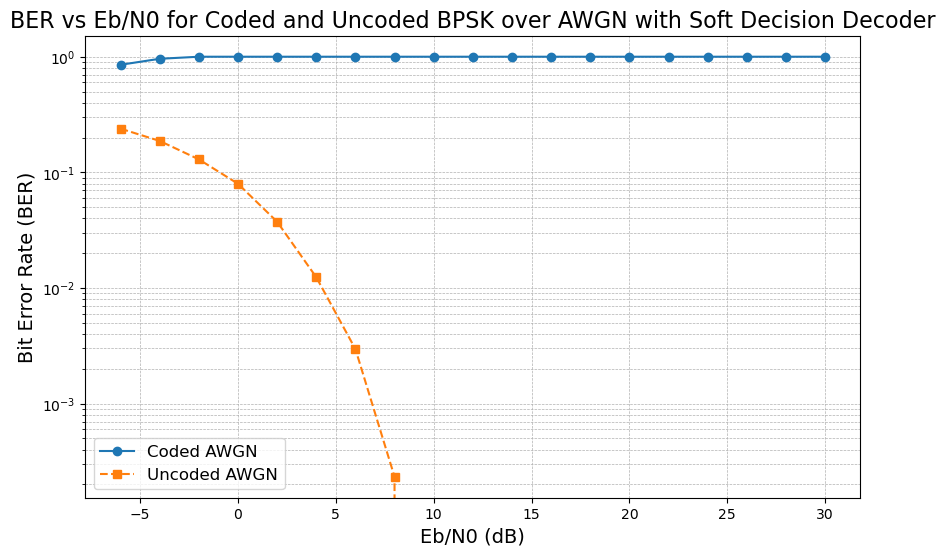

In [20]:
plt.figure(figsize=(10, 6))
snr_values_np = np.array(snr_values)
# Plot the BER for the autoregressive approach
plt.plot(snr_values_np, ber_coded_list_awgn, marker='o', linestyle='-', label='Coded AWGN')
# Plot the BER for the packetwise approach
plt.plot(snr_values_np, ber_uncoded_list_awgn, marker='s', linestyle='--', label='Uncoded AWGN')
# Set the y-axis to a logarithmic scale
plt.yscale('log')
plt.xlabel('Eb/N0 (dB)', fontsize=14)
plt.ylabel('Bit Error Rate (BER)', fontsize=14)
plt.title('BER vs Eb/N0 for Coded and Uncoded BPSK over AWGN with Soft Decision Decoder', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [ ]:
# def packetwise_coded(Fd, Fs, N, SNR, n, d_v, d_c):
#     H, G = make_ldpc(n, d_v, d_c, systematic=True, sparse=True)
#     k = G.shape[1]
#     rate = k/n
#     snr_coded = SNR - 10 * np.log10(rate)
#     # N is the number of message bits we want to transmit
#     # But we want to send more than N symbols, and k is a fixed value, so we need to compute the number of symbols, and channel values, to generate
#     N1 = number_of_symbols(N, n, d_v, d_c)
#     generate_channels_for_doppler_frequencies(Fd, Fs, N1)

#     # Load the complex channel values from the file.
#     with open("channels.txt", "r") as f:
#         channel_vals = [json.loads(line)[0] for line in f]
#     channel_vals = np.array([complex(re, im) for re, im in channel_vals])

    
#     # Initialize variables for simulation.
#     current_index = 0  # Track the current position in channel values.
#     total_packets = 0  # Total number of transmitted data bits.
#     wrong_packets = 0  # Count of incorrectly received data bits.
#     actual_channels = []  # Store actual channel values.
    
#     while current_index < N1:
#         pilot_bit = generate_random_symbols(1) 
#         actual_channel = channel_vals[current_index:current_index + 1] 
#         current_index += 1
#         actual_channels.append(actual_channel[0])  
#         received_pilot = transmit_data(pilot_bit, actual_channel, snr_coded)  # Transmit and receive the pilot signal.
#         estimated_channel = estimate_channel(received_pilot, pilot_bit)  # Estimate the channel from the pilot, which is assumed to be the channel for all the k data packets that follow

#         #Encoding the data packet which is sent after the pilot
#         packet_message = np.random.randint(2, size=k)

#         #The encoded packet is n symbols long
#         encoded_packet_symbols = encode_custom(G, packet_message) 
#         actual_channel = channel_vals[current_index:current_index + n]
#         current_index += n
#         received_symbols = transmit_data(encoded_packet_symbols, actual_channel, snr_coded) 
#         #Assume the pilot's channel is constant over the packet, which requires the coherence time to be appropriately set
#         estimated_bits = decoder_custom_jakes(received_symbols, estimated_channel)

#         #Now decoding of the LDPC code must be done to get the transmitted original packet back
#         recovered_message = get_message(G, estimated_bits)
        
#         total_packets += len(recovered_message)
#         for i in range(len(packet_message)):
#             if packet_message[i] != recovered_message[i]:
#                 wrong_packets += 1
                
#     #Return the BER            
#     if total_packets == 0:
#         return None  # Return None if no packets were transmitted.
#     else:
#         return np.float16(wrong_packets / total_packets)

In [ ]:
# def packetwise_simulate(Fd, Fs, N, SNR):
#     generate_channels_for_doppler_frequencies(Fd, Fs, N)
#     with open("channels.txt", "r") as f:
#         channel_vals = [json.loads(line)[0] for line in f]
#     channel_vals = np.array([complex(re, im) for re, im in channel_vals])
    
#     # Initialize variables for simulation.
#     current_index = 0  # Track the current position in channel values.
#     total_packets = 0  # Total number of transmitted data bits.
#     wrong_packets = 0  # Count of incorrectly received data bits.
#     actual_channels = []  # Store actual channel values.
    
#     # Simulate the transmission of packets, each with 1 pilot and 3 data bits.
#     while current_index < N - 12:  # Ensure enough channel values remain for the packet.
#         # Transmit a single pilot bit, which acts as a header for the entire 4-bit packet.
#         pilot_bit = generate_random_symbols(1)
#         actual_channel = channel_vals[current_index:current_index + 1]  
#         actual_channels.append(actual_channel[0])  
#         received_pilot = transmit_data(pilot_bit, actual_channel, SNR)  # Transmit and receive the pilot signal.
#         estimated_channel = estimate_channel(received_pilot, pilot_bit)  # Estimate the channel from the pilot, which is assumed to be the channel for all the 3 data packets that follow
#         # Move to the next index for data transmission.
#         current_index += 1
#         # Generate 3 data bits for the data packet.
#         data_bits = generate_random_symbols(11)
#         # Check if enough channel values are available for the data packet.
#         if current_index + 11 >= len(channel_vals):
#             break
#         # Use three consecutive channel values for data transmission.
#         actual_channel = channel_vals[current_index:current_index + 11]
#         # Transmit and receive the data packet.
#         received_data = transmit_data(data_bits, actual_channel, SNR) 
#         # Estimate the transmitted data bits using the channel of the pilot that we estimated earlier. 
#         estimated_data_bits = np.sign(np.real(received_data * estimated_channel.conjugate() / (abs(estimated_channel))**2))
        
#         # Update the total transmitted packets and count the errors.
#         total_packets += 11
#         for i in range(11):  # Compare each transmitted bit with the estimated bit.
#             if data_bits[i] != estimated_data_bits[i]:
#                 wrong_packets += 1

#         # Move the index forward by 3 for the next 4-bit (1 header + 3 data) packet transmission.
#         current_index += 11
#     # Calculate and return the Bit Error Rate (BER).
#     if total_packets == 0:
#         return None  # Return None if no packets were transmitted.
#     else:
#         return np.float16(wrong_packets / total_packets)


In [ ]:
# #Demo with 11 bits (0 and 1) to be transmitted
# #0 becomes 1 and 1 becomes -1 in symbol, coding is done before converting to a symbol, and decoding of the message occurs after converting the symbols to bits
# n1 = 18
# d_v1 = 3
# d_c1 = 6
# snr = 10
# k = 11 #fixed if we fix the other 3 (not snr)
# Fs = 100000
# Fd = 100
# N = 100000
# SNR = 10
# mse_threshold = 0.1

In [ ]:
# ber = packetwise_coded(Fd, Fs, N, SNR, n1, d_v1, d_c1)
# print(ber)

In [ ]:
# ber = packetwise_simulate(Fd, Fs, N, SNR)
# print(ber)

In [ ]:
# # Define the range of SNR values to be simulated
# snr_values = [-8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
# N = 100000
# Fs = 100000
# Fd = 100
# n1 = 18
# d_v1 = 3
# d_c1 = 6

# # Initialize lists to store BER for the two approaches
# ber_coded_list = []  # BER for the autoregressive approach
# ber_uncoded_list = []  # BER for the packetwise approach

# # Simulation loop for each SNR value
# # The simulation is peformed 3 times to ensure averaging and smoothness of the curve
# for snr in snr_values:
#     ber_coded_sum = 0  # For autoregressive approach
#     ber_uncoded_sum = 0  # For packetwise approach
#     for i in range(3):
#         ber_coded = packetwise_coded(Fd, Fs, N, SNR, n1, d_v1, d_c1)
#         ber_uncoded = packetwise_simulate(Fd, Fs, N, SNR)
#         ber_coded_sum += ber_coded
#         ber_uncoded_sum += ber_uncoded
#     ber_coded_list.append(ber_coded_sum / 3)
#     ber_uncoded_list.append(ber_uncoded_sum / 3)


In [ ]:
# plt.figure(figsize=(10, 6))
# snr_values_np = np.array(snr_values)
# # Plot the BER for the autoregressive approach
# plt.plot(snr_values_np, ber_coded_list, marker='o', linestyle='-', label='Coded Packetwise Approach')
# # Plot the BER for the packetwise approach
# plt.plot(snr_values_np, ber_uncoded_list_awgn, marker='s', linestyle='--', label='Uncoded Packetwise Approach')
# # Set the y-axis to a logarithmic scale
# plt.yscale('log')
# plt.xlabel('Eb/N0 (dB)', fontsize=14)
# plt.ylabel('Bit Error Rate (BER)', fontsize=14)
# plt.title('BER vs Eb/N0 for Coded and Uncoded versions of Packetwise approaches', fontsize=16)
# plt.legend(fontsize=12)
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)
# plt.show()